# Xác định các khoản vay an toàn với Decision Tree (DT)
[LendingClub](https://www.lendingclub.com/) là một công ty cho vay ngang hàng kết nối trực tiếp người đi vay và người cho vay/nhà đầu tư tiềm năng. Trong notebook này, chúng ta sẽ xây dựng một mô hình phân loại để dự đoán xem khoản vay do LendingClub cung cấp có khả năng [vỡ nợ](https://en.wikipedia.org/wiki/Default_%28finance%29) hay không.

Trong notebook này, chúng ta sẽ sử dụng dữ liệu từ LendingClub để dự đoán xem một khoản vay sẽ được trả đầy đủ, bị [khoanh nợ](https://en.wikipedia.org/wiki/Charge-off) hay có thể bị vỡ nợ. Trong lab này, chúng ta sẽ:

* Sử dụng Pandas để thực hiện một số kỹ thuật đặc trưng.
* Huấn luyện DT  trong tập dữ liệu LendingClub.
* Hiển thị cây.
* Dự đoán xem một khoản vay có bị vỡ nợ hay không với xác suất dự đoán (trong tập kiểm định).
* Huấn luyện một mô hình cây phức tạp và so sánh với mô hình cây đơn giản.

Bắt đầu thôi!

In [50]:
# Import một số thư viện

import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load tập dữ liệu LendingClub 
Chúng ta sẽ sử dụng tập dữ liệu từ [LendingClub](https://www.lendingclub.com/)

In [51]:
loans_df = pandas.read_csv('datasets/lending-club-data.csv', low_memory=False)

## Khám phá một số đặc trưng

Hãy nhanh chóng khám phá xem tập dữ liệu trông như thế nào. Đầu tiên, hãy in tên cột để xem chúng ta có những đặc trưng nào trong tập dữ liệu này.

In [52]:
loans_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Khám phá cột mục tiêu

Cột mục tiêu (cột nhãn) mà chúng ta quan tâm trong tập dữ liệu là `bad_loans`. Trong cột này, **1** tức là khoản vay rủi ro và **0** tức là khoản vay an toàn.

Để trực quan hơn va thống nhất với bài giảng, chúng ta gán lại các mục tiêu:
* **+1** là khoản vay an toàn, 
* **-1** là khoản vay rủi ro. 

Chúng ta đặt nó vào cột mới là `safe_loans`.

In [53]:
# safe_loans =  1 => an toàn
# safe_loans = -1 => rủi ro
loans_df['safe_loans'] = loans_df['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans_df.drop(columns=['bad_loans'])

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none,safe_loans
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1,-1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,1.0,1.0,1.0,0,8.275850,20141201T000000,0,1,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,1.0,1.0,1.0,0,5.215330,20141201T000000,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122602,9856168,11708132,6000,6000,6000,60 months,23.40,170.53,E,E5,...,0.0,1.0,1.0,1,4.487630,20190101T000000,0,1,0,-1
122603,9795013,11647121,15250,15250,15250,36 months,17.57,548.05,D,D2,...,0.0,0.0,1.0,0,10.117800,20170101T000000,0,0,0,1
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0,-1
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1,-1


Giờ hãy khám phá phân phối của cột `safe_loans`. Điều này cho biết có bao nhiêu khoản vay an toàn và rủi ro hiện có trong tập dữ liệu.

array([[<AxesSubplot:title={'center':'safe_loans'}>]], dtype=object)

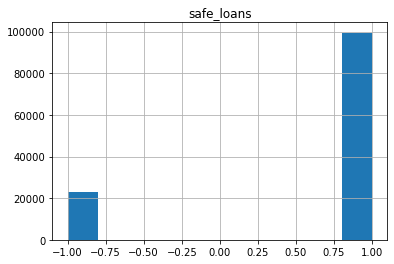

In [54]:
loans_df.hist(column='safe_loans')

## Các đặc trưng cho thuật toán phân loại
Ở phần này, chúng ta sẽ sử dụng tập con các đặc trưng (hạng mục hoặc số). Các đặc trưng sẽ sử dụng được **mô tả ở chú thích code** dưới đây. Nếu đam mê về tài chính, hãy ghé trang web [LendingClub](https://www.lendingclub.com/) để biết thêm chi tiết về các đặc trưng này. 

In [55]:
features = ['grade',                     # cấp bậc khoản vay
            'sub_grade',                 # sub-grade của khoản vay
            'short_emp',                 # làm việc được một năm hoặc ít hơn
            'emp_length_num',            # số năm làm việc
            'home_ownership',            # tình trạng sở hữu nhà ở: sở hữu, thế chấp hoặc cho thuê
            'dti',                       # tỷ lệ nợ trên thu nhập
            'purpose',                   # mục đích khoản vay
            'term',                      # thời hạn khoản vay
            'last_delinq_none',          # người vay có phạm pháp không
            'last_major_derog_none',     # người vay có mức đánh giá 90 ngày hoặc ít hơn
            'revol_util',                # % tín dụng khả dụng đang được sử dụng
            'total_rec_late_fee',        # tổng phí trễ nhận được theo ngày
           ]

target = 'safe_loans'                   # dự đoán mục tiêu (y) (+1 là safe, -1 là risky)

# Trích xuất các cột đặc trưng và mục tiêu
loans_df = loans_df[features + [target]]

Chúng ta còn một **tập con đặc trưng** và **mục tiêu** để sử dụng cho phần còn lại của notebook.

## Dữ liệu mẫu để cân bằng các lớp

Như đã khám phá ở trên, dữ liệu của chúng ta có đầy đủ các khoản vay an toàn không cân đối. Hãy tạo hai tập dữ liệu: một tập dữ liệu chỉ chứa các khoản vay an toàn (`safe_loans_raw`) và một tập dữ liệu chỉ chứa các khoản vay rủi ro (`risky_loans_raw`). 

In [56]:
safe_loans_raw = loans_df[loans_df[target] == +1]
risky_loans_raw = loans_df[loans_df[target] == -1]
print ("Number of safe loans  : %s" % safe_loans_raw.shape[0])
print ("Number of risky loans : %s" % risky_loans_raw.shape[0])

Number of safe loans  : 99457
Number of risky loans : 23150


Hãy viết code để tính phần trăm các khoản vay an toàn và rủi ro đưới đây trong tập dữ liệu và xác thực các con số này với những gì đã cho bằng cách sử dụng `.show` trước đó trong lab:

In [57]:
print ("Percentage of safe loans  : {}".format(safe_loans_raw.shape[0]/loans_df.shape[0])) 
print ("Percentage of risky loans : {}".format(risky_loans_raw.shape[0]/loans_df.shape[0]))

Percentage of safe loans  : 0.8111853319957262
Percentage of risky loans : 0.18881466800427382


Một cách để chống lại mất cân bằng lớp là giảm số lượng lớp lớn hơn cho đến khi phân phối của lớp còn khoảng một nửa. Ở đây, chúng ta sẽ giảm số lượng lớp lớn hơn (khoản vay an toàn) để cân bằng tập dữ liệu. Điều này có nghĩa là chúng ta đang loại bỏ nhiều điểm dữ liệu. Hãy sử dụng `seed=1` để mọi người đều nhận được kết quả như nhau.

In [58]:
# Vì khoản vay rủi ro ít hơn so với khoản vay an toàn, hãy tìm tỷ lệ kích thước
# và sử dụng % đó để giảm mẫu khoản vay an toàn.
percentage = risky_loans_raw.shape[0]/safe_loans_raw.shape[0]

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Nối risky_loans với phiên bản safe_loans đã lấy mẫu xuống
loans_data = risky_loans.append(safe_loans)

Bây giờ, hãy xác minh rằng tỷ lệ kết quả của các khoản vay an toàn và rủi ro là gần 50%.

In [59]:
print ("Percentage of safe loans                 : {}".format(safe_loans.shape[0] / loans_data.shape[0]))
print ("Percentage of risky loans                : {}".format(risky_loans.shape[0] / loans_data.shape[0]))
print ("Total number of loans in our new dataset : {}".format(loans_data.shape[0]))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


**Lưu ý:** Có nhiều cách xử lý dữ liệu mất cân bằng, bao gồm sửa đổi thuật toán tìm hiểu. Các cách tiếp cận này nằm ngoài phạm vi của khóa học, nhưng một số phương pháp được xem xét trong [bài viết sau](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). Với nhiệm vụ này, chúng ta sẽ sử dụng cách tiếp cận đơn giản nhất có thể, lấy mẫu con của lớp bị biểu diễn quá mức để có được tập dữ liệu cân bằng hơn; đặc biệt, khi dữ liệu vô cùng mất cân bằng, chúng ta được khuyến nghị sử dụng các phương pháp nâng cao hơn.

# Mã hóa One-hot
Để triển khai decision tree của scikit-learn, cần các giá trị số cho ma trận dữ liệu của nó. Điều này có nghĩa là chúng ta sẽ phải biến các biến hạng mục thành các đặc trưng nhị phân thông qua mã hóa one-hot.

In [60]:
print(loans_data.dtypes)
categorical_variables = list(loans_data.select_dtypes(include=['object']).columns)
print(categorical_variables)

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                 int64
dtype: object
['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']


In [61]:
one_hot_data = pandas.get_dummies(loans_data[categorical_variables], prefix=categorical_variables)
# cần thêm tại đây để loại cột.
loans_data.drop(columns=categorical_variables, axis=1, inplace=True)
loans_data = pandas.concat([loans_data, one_hot_data], axis=1)

## Chia dữ liệu thành tập huấn luyện và tập kiểm định

Chúng ta chia dữ liệu thành tập huấn luyện và kiểm định bằng cách sử dụng phân chia 80/20 và chỉ định `seed=1` để mọi người đều nhận được kết quả tương tự. 
<br>
**Lưu ý:** Trong các nhiệm vụ trước, chúng ta gọi đây là **train-test split** (phân tách huấn luyện - kiểm tra). Tuy nhiên, phần dữ liệu mà chúng ta không huấn luyện sẽ được dùng để lựa chọn **tham số mô hình** (lựa chọn mô hình). Do đó, phần dữ liệu này nên được gọi là **tập kiểm định**. Nhớ lại rằng việc kiểm tra chất lượng của các mô hình tiềm năng khác nhau (mô hình có các tham số khác nhau) phải được thực hiện trên tập kiểm định, trong khi đánh giá mô hình được lựa chọn cuối cùng luôn được thực hiện trên dữ liệu kiểm tra. Thông thường, chúng ta cũng sẽ lưu một phần dữ liệu (tập kiểm tra thực) để kiểm tra mô hình cuối cùng  hoặc sử dụng kiểm định chéo trên tập huấn luyện để chọn mô hình cuối cùng. Nhưng trong bài này, chúng ta sẽ không làm điều đó.

In [62]:
np.random.seed(1)

train_data, val_data = train_test_split(loans_data, test_size=0.2)

# in ra (train_data[target])

train_y = train_data[target].values
train_data.drop(columns=[target], inplace=True)
train_X = train_data.values

val_y = val_data[target].values
val_data.drop(columns=[target], inplace=True)
val_X = val_data.values

# Sử dụng decision tree để xây dựng phân loại
Bây giờ, hãy sử dụng decision tree được tích hợp sẵn của scikit-learn: [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) để tạo mô hình dự đoán khoản vay trên dữ liệu huấn luyện. Để thực hiện điều này, chúng ta cần **import sklearn, sklearn.tree và numpy.**
<br>
Lưu ý: Trước tiên, cần chuyển đổi DataFrame thành một ma trận dữ liệu numpy và trích xuất các nhãn mục tiêu thành mảng numpy. Xem API để biết thêm thông tin. Đảm bảo đặt max_depth = 6.

Gọi mô hình sau: decision_tree_model.

Và cũng huấn luyện cây với max_depth=2. Gọi mô hình small_model.

In [63]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth=6)
small_model = DecisionTreeClassifier(max_depth=2)

In [64]:
decision_tree_model.fit(train_X, train_y)
small_model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=2)

[Text(0.5540865384615384, 0.9285714285714286, 'X[7] <= 0.5\ngini = 0.5\nsamples = 37040\nvalue = [18547, 18493]'),
 Text(0.2956730769230769, 0.7857142857142857, 'X[8] <= 0.5\ngini = 0.496\nsamples = 31864\nvalue = [17304, 14560]'),
 Text(0.15384615384615385, 0.6428571428571429, 'X[6] <= 0.175\ngini = 0.482\nsamples = 21751\nvalue = [12959, 8792]'),
 Text(0.07692307692307693, 0.5, 'X[9] <= 0.5\ngini = 0.487\nsamples = 20525\nvalue = [11907, 8618]'),
 Text(0.038461538461538464, 0.35714285714285715, 'X[65] <= 0.5\ngini = 0.464\nsamples = 11607\nvalue = [7354, 4253]'),
 Text(0.019230769230769232, 0.21428571428571427, 'X[52] <= 0.5\ngini = 0.432\nsamples = 5645\nvalue = [3867, 1778]'),
 Text(0.009615384615384616, 0.07142857142857142, 'gini = 0.456\nsamples = 3372\nvalue = [2187, 1185]'),
 Text(0.028846153846153848, 0.07142857142857142, 'gini = 0.386\nsamples = 2273\nvalue = [1680, 593]'),
 Text(0.057692307692307696, 0.21428571428571427, 'X[2] <= 19.935\ngini = 0.486\nsamples = 5962\nvalue =

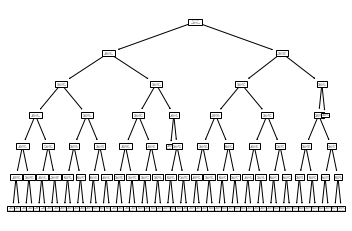

In [65]:
# Draw decision tree model
from sklearn import tree

tree.plot_tree(decision_tree_model)

# Đưa ra dự đoán

Xem xét hai ví dụ tích cực và tiêu cực từ **tập kiểm định** và xem mô hình đưa ra dự đoán gì. Chúng ta sẽ thực hiện như sau:
* Dự đoán xem một khoản vay có an toàn hay không.
* Dự đoán xác suất để khoản vay đó an toàn.

In [66]:
validation_safe_loans = val_data[val_y == 1]
validation_risky_loans = val_data[val_y == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,grade_A,grade_B,grade_C,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
83265,0,11,5.92,1,1,19.2,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
89463,0,4,11.49,1,1,61.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
121355,0,11,15.90,1,1,59.7,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
39588,0,11,1.51,0,1,20.4,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Khám phá nhãn dự đoán
Chúng ta sẽ sử dụng mô hình để dự đoán xem một khoản vay có khả năng vỡ nợ hay không. Với từng hàng trong **sample_validation_data**, sử dụng **decision_tree_model** để dự đoán xem khoản vay có được phân loại là **khoản vay an toàn** hay không.

**Gợi ý:** Đảm bảo sử dụng phương thức `.predict()`.

In [75]:
# VIẾT CODE Ở ĐÂY
decision_tree_model.predict(sample_validation_data)

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([ 1, -1, -1,  1])

## Khám phá xác suất dự đoán

Với từng hàng trong **sample_validation_data**, xác suất (theo **decision_tree_model**) để một khoản vay được phân loại là **an toàn** là bao nhiêu?

In [76]:
decision_tree_model.predict_proba(sample_validation_data)

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.4591029 , 0.5408971 ],
       [0.50706436, 0.49293564],
       [0.54930305, 0.45069695],
       [0.42893037, 0.57106963]])

# Đánh giá accuracy của mô hình decision tree
Nhắc lại: accuracy được xác định như sau:
$$
\text{accuracy} = \frac{\text{\# ví dụ được phân loại chính xác}}{\text{\# tổng số ví dụ}}
$$

Hãy bắt đầu đánh giá accuracy của `small_model` và `decision_tree_model` trong dữ liệu huấn luyện và kiểm định.

In [77]:
# VIẾT CODE Ở ĐÂY
print (decision_tree_model.score(train_X, train_y))
print (small_model.score(train_X, train_y))
print ('----------')
print (decision_tree_model.score(val_X, val_y))
print (small_model.score(val_X, val_y))

0.6374460043196545
0.6139578833693304
----------
0.6317494600431965
0.6171706263498921


**Quiz:** accuracy của `decision_tree_model` trên tập kiểm định được làm tròn đến 0.01 là bao nhiêu?
<br>
**Đáp án của bạn:** 0.63

## Đánh giá accuracy của một mô hình DT phức tạp 

Chúng ta sẽ huấn luyện một decision tree lớn với `max_depth=10`. Điều này sẽ khiến cây đã tìm hiểu sâu hơn và dẫn đến một mô hình rất phức tạp. Nhớ lại trong bài giảng, chúng ta chuộng các mô hình đơn giản hơn mà vẫn có khả năng dự đoán tương tự. Đây sẽ là ví dụ về một mô hình phức tạp hơn, có khả năng dự đoán tương tự, chúng ta không muốn nó.

In [78]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model.fit(train_X, train_y)
print (big_model.score(train_X, train_y))
print (big_model.score(val_X, val_y))

0.6610151187904968
0.6254859611231102


**Checkpoint:** Chúng ta thấy rằng **big_model** ở tập huấn luyện có chất lượng tốt hơn so với **decision_tree_model** đã thực hiện trong tập huấn luyện.

**Quiz:** Làm thế nào để so sánh chất lượng của **big_model** với **decision_tree_model** trong tập kiểm định? Đây có phải là dấu hiệu của overfitting?
<br>
**Đáp án của bạn:** so với **decision_tree_model** thì **big_model** có biên độ tăng độ chính xác trên tập huấn luyện cao hơn nhiều so với trên tập validation, do đó đã có dấu hiệu của overfiting

### Định lượng chi phí sai sót

Mọi sai sót mà mô hình mắc đều phải trả giá. Trong phần này, chúng ta sẽ thử định lượng chi phí của mỗi sai sót mà mô hình mắc phải.

Giả sử như sau:

* **False negative**: Các khoản cho vay thực sự an toàn nhưng lại được dự đoán là rủi ro. Điều này dẫn đến chi phí cơ hội của việc mất một khoản vay mà lẽ ra phải được chấp nhận.
* **False positive**: Các khoản cho vay thực sự rủi ro nhưng lại được dự đoán là an toàn. Chúng đắt hơn nhiều vì nó dẫn đến một khoản vay rủi ro.
* **Dự đoán đúng**: Tất cả các dự đoán đúng thường không phải chịu bất kỳ chi phí nào.


Hãy viết code tính toán chi phí sai sót của mô hình. Hoàn thành 4 bước sau:
1. Đầu tiên, hãy tính toán các dự đoán do mô hình đưa ra.
1. Thứ hai, tính số lượng false positive.
2. Thứ ba, tính tính số lượng false negative.
3. Cuối cùng, tính toán chi phí sai sót của mô hình bằng cách cộng chi phí của true positive và false positive. 

Trước tiên, hãy đưa ra dự đoán trên `validation_data`, sử dụng `decision_tree_model`:

In [79]:
predictions = decision_tree_model.predict(val_data)

/Users/ngothai/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


**False positive** là các dự đoán mà mô hình dự đoán +1 nhưng nhãn thực là -1. Hoàn thành khối code sau cho số lượng các false positive: 

In [88]:
# VIẾT CODE Ở ĐÂY
temp = predictions - val_y

# +1 - (-1) = 2
false_pos_count = temp[temp == 2].shape[0]
false_pos_count


1423

In [89]:
# OR
[1 if predictions[i] == +1 and val_y[i] == -1 else 0 for i in range(val_y.shape[0])].count(1)

1423

**False negative** là các dự đoán mà mô hình dự đoán -1 nhưng nhãn thực là +1. Hoàn thành khối code sau cho số lượng false negative: 

In [91]:
# VIẾT CODE Ở ĐÂY
# -1 - 1 = -2
false_neg_count = temp[temp == -2].shape[0]
false_neg_count

1987

In [92]:
# OR
[1 if predictions[i] == -1 and val_y[i] == +1 else 0 for i in range(val_y.shape[0])].count(1)

1987

**Quiz:** Giả sử mỗi sai sót đều phải trả phí:
* Phí là \$10,000 cho mỗi false negative.
* Phí là \$20,000 cho mỗi false positive.

Tổng chi phí của cho các sai sót bởi `decision_tree_model` trong `validation_data` là bao nhiêu?
<br>
**Đáp án của bạn:**

In [94]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
# VIẾT CODE Ở ĐÂY
cost = false_neg_count * 10000 + false_pos_count * 20000
print (locale.currency(cost, grouping=True))

$48,330,000.00
